<a href="https://colab.research.google.com/github/Shushrruth/Micro-RNA/blob/main/Micro_RNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!gdown --id 1iCs89rJZ-Kbea2IJty8KBJEvXKQ1-fIQ
!gdown --id 11cK30co_GQ3b5dWAnTLjUpejaErLd3Ar

Downloading...
From: https://drive.google.com/uc?id=1iCs89rJZ-Kbea2IJty8KBJEvXKQ1-fIQ
To: /content/hsa-pre-release22.fa.txt
100% 267k/267k [00:00<00:00, 8.63MB/s]
Downloading...
From: https://drive.google.com/uc?id=11cK30co_GQ3b5dWAnTLjUpejaErLd3Ar
To: /content/human_neg.fa.txt
100% 759k/759k [00:00<00:00, 12.0MB/s]


In [ ]:
import pandas as pd
Positive = pd.read_csv('hsa-pre-release22.fa.txt',sep ='\n',header=None).values[1::2]
Negative = pd.read_csv('/content/human_neg.fa.txt',sep ='\n',header=None).values[1::2]

In [ ]:
def clean(file):

  for i in range(len(file)):
    if len(file[i][0]) == 180:
       continue
    
    if len(file[i][0]) < 180:
      n = 180 - len(file[i][0])

      for j in range(n//2):
        file[i][0] = file[i][0] + 'N'
      
      for j in range(n//2):
        file[i][0] = 'N' + file[i][0]

    if len(file[i][0]) > 180:
      n = len(file[i][0])//2

      file[i][0] = file[i][0][n-90:n+90]

    if len(file[i][0]) == 179:
      file[i][0] +='N'

  return file

In [ ]:
Positive = clean(Positive)
Negative = clean(Negative)

lenp = len(Positive)//10
Negative = Negative[:len(Positive)]
Ptrain, Ptest = Positive[lenp:], Positive[:lenp]
Ntrain, Ntest = Negative[lenp:], Negative[:lenp]

In [ ]:
import cv2
import numpy as np
import os
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms
import torchvision
from torch.nn import functional as F
from PIL import Image

class Data(Dataset):
    
    def __init__(self, data, label):
        
        self.data= data
        self.label=label


    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        i=self.data[index]
        ctr=1
        ctri=0
        ar=np.zeros((len(i[0]),4))
        
        for s in i[0][1:]:
            if s=='A':
                ar[ctr,0]=1
            elif s=='U':
                ar[ctr,1]=1
            elif s=='C':
                ar[ctr,2]=1
            elif s=='G':
                ar[ctr,3]=1

            ctr+=1
        
        ar=torch.tensor(ar).float().permute(1,0)
        label=torch.tensor(self.label).float()
        return ar,label

In [ ]:
train_datasets=[]

print('###')
len_0=0

for file_ in [Ntrain]:

    d=Data(file_,0)
    len_0+=len(d)
    train_datasets.append(d)

print("Train Length Negatives: {}".format(len_0))

len_0=0
for file_ in [Ptrain]:
    d=Data(file_,1)
    len_0+=len(d)
    train_datasets.append(d)

print("Train Length Positives: {}".format(len_0))

train_dataset=torch.utils.data.ConcatDataset(train_datasets)
print(len(train_dataset))

########################
test_datasets=[]

print('###')
len_0=0

for file_ in [Ntest]:

    d=Data(file_,0)
    len_0+=len(d)
    test_datasets.append(d)

print("Test Length Negatives: {}".format(len_0))

len_0=0
for file_ in [Ptest]:
    d=Data(file_,1)
    len_0+=len(d)
    test_datasets.append(d)

print("Test Length Positives: {}".format(len_0))

test_dataset=torch.utils.data.ConcatDataset(test_datasets)
print(len(test_dataset))

###
Train Length Negatives: 1726
Train Length Positives: 1726
3452
###
Test Length Negatives: 191
Test Length Positives: 191
382


In [ ]:
'''


Model architecture


'''


import torch
from torch import nn
from torch.nn import functional as F

import torch.nn.functional as F
from torch.nn import MaxPool1d

class Net(nn.Module):
    def __init__(self, in_channels=4, out_channels=1):
        super(Net, self).__init__()

        self.Conv1 = nn.Conv1d(in_channels= 4, out_channels= 160, kernel_size= 3)

        self.Conv2 = nn.Conv1d(in_channels= 160, out_channels= 320, kernel_size= 3)

        self.Maxpool = nn.MaxPool1d(kernel_size= 2, stride= 2)

        self.Drop2 = nn.Dropout(0.2)

        #88x320

        self.BiLSTM1 = nn.LSTM(input_size=88, hidden_size=32, num_layers=2,
                                 batch_first=True,
                                 dropout=0.5,
                                 bidirectional=True)
      
        self.Linear1 = nn.Linear(320*32*2, 128)

        self.Linear2 = nn.Linear(128,1)

        

    def forward(self, input):

        x = self.Conv1(input)

        x = F.relu(x)

        x = self.Conv2(x)

        x = F.relu(x)

        x = self.Maxpool(x)

        x = self.Drop2(x)

        x,_ = self.BiLSTM1(x)

        x = torch.flatten(x,1)

        x = self.Linear1(x)

        x = F.relu(x)

        x = self.Linear2(x)

        x = torch.sigmoid(x)

        return x 


k=torch.rand(1,4,180).cuda()
Net().cuda()(k.float())

tensor([[0.5029]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [ ]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import classification_report



def main():
    # Training settings

    use_cuda = True
    gamma=0.7
    save_model=True
    batch_size=64
    test_batch_size=128

    epochs=200
    device = torch.device("cuda" if use_cuda else "cpu")

   
    
    

    train_loader = torch.utils.data.DataLoader(train_dataset, shuffle=True,batch_size=10)
    test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=True,batch_size=test_batch_size)

    model = Net().cuda()#.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    print("Training on {} Samples".format(len(train_loader.dataset)))
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
    min_loss=10000
    for epoch in range(1, epochs + 1):
        print("Epoch {}".format(epoch))
        model.train()
        log_interval=10
        loss_sum=0.0
        from tqdm.auto import tqdm
        correct=0
        for (data, target) in tqdm(train_loader):
            data, target = data.to(device), target.to(device)
                
            optimizer.zero_grad()
            output = model(data).squeeze()

            loss = nn.BCELoss()(output, target)
            loss.backward()
            loss_sum+=float(loss)/(len(train_loader.dataset)//data.shape[0])
            optimizer.step()
            
            prob = (output)
            prob[prob>=0.5]=1
            prob[prob<0.5]=0
            correct += torch.sum(prob==target)
            
        train_loss=loss_sum

        print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            train_loss, correct, len(train_loader.dataset),
            100. * correct / len(train_loader.dataset)))
        
        print('Epoch {} Train loss {}'.format(epoch, loss_sum))

        model.eval()
        test_loss = 0
        correct = 0
        y_pred=[]
        y_true=[]
        y_proba=[]
        with torch.no_grad():


            for data, target in tqdm(test_loader):
                data, target = data.to(device), target.to(device)       
                output = model(data).squeeze()
                test_loss += nn.BCELoss()(output, target).item()*1e+1  # sum up batch loss
                prob = (output)
                y_probas=prob.cpu().numpy()
                
                prob[prob>=0.5]=1
                prob[prob<0.5]=0
                correct += torch.sum(prob==target)
                for i in range(len(prob)):
                    y_proba.append(float(y_probas[i]))
                    y_pred.append(float(prob[i]))
                    y_true.append(float(target[i]))
            

            target_names = ['Negative', 'Positive']

            print(classification_report(y_true, y_pred, target_names=target_names))

        test_loss /= len(test_loader.dataset)
        if test_loss<min_loss:
            min_loss=test_loss
            torch.save(model.state_dict(),'checkpoint_loop.pt')
            torch.save(model.state_dict(),'/content/drive/MyDrive/miR_DL/miR_model_1_jan18.pt')

        
        scheduler.step(test_loss)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))


if __name__ == '__main__':
    main()

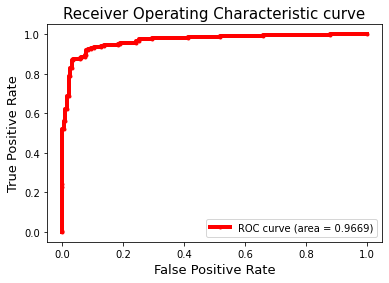

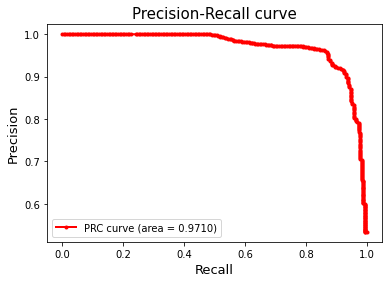

In [ ]:
from sklearn.metrics import classification_report
testloader = torch.utils.data.DataLoader(test_dataset, shuffle=True,batch_size=128)
testloader=testloader
from tqdm.auto import tqdm
model=Net().cuda()
model.load_state_dict(torch.load('/content/drive/MyDrive/miR_DL/miR_model_1_jan18.pt'))
model.eval()
test_loss = 0
correct = 0
y_pred=[]
y_true=[]
y_proba=[]
with torch.no_grad():

    for data, target in tqdm(testloader):
        data, target = data.cuda(), target.cuda()

        output = model(data).squeeze()
        test_loss += nn.BCELoss()(output, target).item()*1e+1
        prob = (output)
        y_probas=prob.cpu().numpy()
        
        prob[prob>=0.5]=1
        prob[prob<0.5]=0
        correct += torch.sum(prob==target)
        for i in range(len(prob)):
            y_proba.append(float(y_probas[i]))
            y_pred.append(float(prob[i]))
            y_true.append(float(target[i]))


target_names = ['Negative', 'Positive']
rocs(y_true,y_proba)
prcs(y_true,y_proba)

In [ ]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()


sensitivity = tp/(tp+fn)
print('SE =', sensitivity)

specificity = tn/(tn+fp)
print('SP = ',specificity)

ppv = tp/(tp+fp)
print('ppv =', ppv)

F1score = 2*tp/(2*tp + fp + fn)
print('F1score=', Fscore)

Gmean = (sensitivity*specificity)**0.5
print('Gmean = ',Gmean)

accuracy = (tp + tn)/(tp+tn+fp+fn)
print("accuracy = ", accuracy)

SE = 0.8952879581151832
SP =  0.9476439790575916
ppv = 0.9447513812154696
F1score= 0.9193548387096774
Gmean =  0.9210940467892617
accuracy =  0.9214659685863874
